## European streamflow database

#### The main objective of this script is to import the previously processed time-series and stations network and organize then in a single dataframe.




Written by: Thiago Victor Medeiros do Nascimento


Link to database spreadsheet: https://docs.google.com/spreadsheets/d/1xS1mWGolKbkn2xthTIW6QNHNkPVV6TnwWXLgYqxAozM/edit#gid=0

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pymannkendall as mk
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import datetime
import tqdm as tqdm
import os
import glob
import calendar
import seaborn as sns

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
%config Completer.use_jedi = False                           # This improve the auto-fill function

import geospatialfunctions as geospatialfunctions            # Geospatialfunctions is a module with useful functions

First we can set our working directory and check it:

In [3]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

#### Data organization:

At this part the concatenation of all the time series is made, and the main objective is to have a final dataframe with all the daily streamflow information together. 



Countries currently available: 


1. Austria (AT)
2. Belgium (BE)
3. Belarus (BY)
4. Bosnia and Herzegovina (BA)
5. Croatia (HR)
6. Cyprus (CY)
7. Czechia (CZ)
8. Denmark (DK)
9. Estonia (EE)
10. Finland (FI)
11. France (FR)
12. Germany (DE)
13. Greece (GR) ***
14. Great Britain (GB)
15. Hungary (HU) ***
16. Iceland (IS)
17. Ireland (IE)
18. Italy (IT)
19. Latvia (LV)
20. Lithuania (LT)
21. Luxembourg (LU)
22. Netherlands (NL)
23. Northern Ireland (UK)
24. Norway (NO)
25. Poland (PL)
26. Portugal (PT)
27. Romania (RO)
28. Russia (RU)
29. Serbia (RS)
30. Slovakia (SK)
31. Slovenia (SI)
32. Spain (ES)
33. Sweden (SE)
34. Switzerland (CH)


*** Countries requested but not yet available.

#### * Network information lecture per country:

In [4]:
# 1. Austria (< 50% gaps):
network_AT = pd.read_excel(r"Austria\timeseries\network_AT.xlsx")

# Here we convert to 4326:
crs={'init':"epsg:3035"}
geometry=[Point(xy) for xy in zip(network_AT.lon, network_AT.lat)]
geodata=gpd.GeoDataFrame(network_AT,crs=crs, geometry=geometry)

network_AT = geodata.to_crs(epsg = 4326)
network_AT['coord_x'] = network_AT.centroid.x  
network_AT['coord_y'] = network_AT.centroid.y

network_AT.drop(["geometry"], axis = 1, inplace = True)

# Here we clean our dataframe for only the useful columns:
network_AT = network_AT[["govnr", "name", "river", "area_gov", "elev", "coord_x", "coord_y"]]
network_AT.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_AT["country"] = "AT"

# Now we convert the column to str:
network_AT.code = network_AT.code.astype(str)

network_AT

,code,name,river,area,elev,lon,lat,country
0,200048,Schruns (Vonbunweg),Litz,102.0,673,9.913677,47.080301,AT
1,200105,Garsella,Lutz,95.5,730,9.875898,47.226658,AT
2,200154,Laterns,Frutz,33.4,831,9.728853,47.256933,AT
3,200527,Brederis,Ehbach,25.2,427,9.594132,47.283681,AT
4,200428,Schwarzach,Schwarzach,17.7,425,9.758942,47.447480,AT
...,...,...,...,...,...,...,...,...
321,213538,Waldenstein,Waldensteiner Bach,101.0,695,14.873156,46.926405,AT
322,213082,St. Gertraud,Lavant,380.2,512,14.866366,46.885280,AT
323,213314,St. Jakob,Weissenbach,55.9,460,14.834621,46.841073,AT
324,213371,Fischering,Lavant,715.6,410,14.836009,46.783894,AT


In [5]:
# 2. Belgium (<50% gaps):
network_BE = pd.read_excel(r"Julia\timeseries\network_BE.xlsx")
network_BE.code = network_BE.code.astype(str)

network_BE

,code,name,river,area,elev,lon,lat,country
0,10461002,Bierges,Dyle,310.0,NaN,4.606129,50.710583,BE
1,19511002,Tubize,Senne,215.0,NaN,4.196446,50.690256,BE
2,23711002,Ronquieres,Samme,135.0,NaN,4.224809,50.605923,BE
3,29521002,Irchonwelz,DendreOrientale,126.0,NaN,3.751661,50.618903,BE
4,29711002,Ath,DendreOrientale,229.0,NaN,3.777834,50.633521,BE
...,...,...,...,...,...,...,...,...
150,40000002,Zichem,Demer,NaN,NaN,4.991580,51.002599,BE
151,50000001,Hulshout,Grote Nete,NaN,NaN,4.787781,51.061851,BE
152,57000000,Melle,Zeeschelde,NaN,NaN,3.805347,51.004325,BE
153,70000000,Haringe,Ijzer,NaN,NaN,2.608001,50.910322,BE


(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

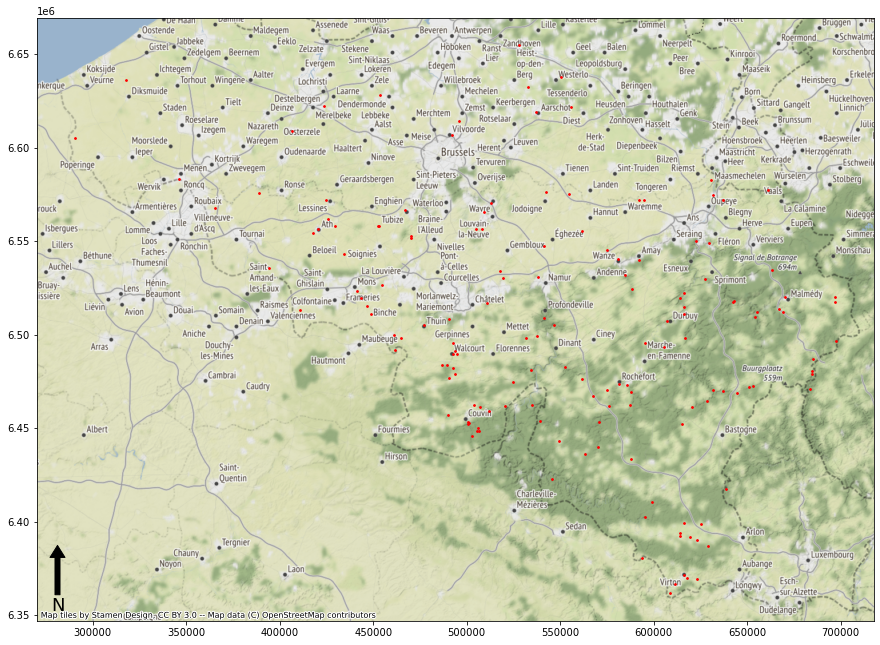

In [6]:
geospatialfunctions.plotpointsmap(network_BE.set_index("code").loc[:, ["lon", "lat"]], showcodes = False, colorpoints="red")

In [7]:
# 3. Belarus (<50% gaps):
network_BY = pd.read_excel(r"GRDC\timeseries\countries\network_BY.xlsx")

# Here we clean our dataframe for only the useful columns:
network_BY = network_BY[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_BY.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_BY["country"] = "BY"

# Now we convert the column to str:
network_BY.code = network_BY.code.astype(str)

network_BY

,code,name,river,area,elev,lon,lat,country
0,6273500,YANKOVO,POLOTA,618,NaN,28.853796,55.544941,BY
1,6274600,STOWBTSY,NEMUNAS,3070,145.0,26.728616,53.469681,BY


In [8]:
# 4. Bosnia and Herzegovina (<50% gaps):
network_BA = pd.read_excel(r"Bosnia\timeseries\network_BA.xlsx")

# Here we clean our dataframe for only the useful columns:
network_BA = network_BA[["Code", "Code", "River", "Area", "Level", "lon", "lat"]]

# For Belgium we do not have the elevation information:
network_BA.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_BA["country"] = "BA"

# Now we convert the column to str:
network_BA.code = network_BA.code.astype(str)

network_BA

,code,name,river,area,elev,lon,lat,country
0,Martin Brod,Martin Brod,Una,1459.0,310.30,16.134492,44.495605,BA
1,Kljuc,Kljuc,Sana,754.0,247.09,16.796308,44.524998,BA
2,Sanski Most,Sanski Most,Sana,2008.0,156.04,16.666267,44.766468,BA
3,Hrustovo,Hrustovo,Sanica,NaN,179.19,16.733665,44.681034,BA
4,Daljan,Daljan,Vrbas,1034.0,516.41,17.402406,44.129210,BA
5,Reljevo,Reljevo,Bosna,1093.0,478.46,18.314335,43.886685,BA
6,Raspotocje,Raspotocje,Bosna,4053.0,312.62,17.926915,44.189623,BA
7,Maglaj Poljice,Maglaj Poljice,Bosna,6540.0,164.80,18.100984,44.566758,BA
8,Merdani,Merdani,Lasva,950.0,357.59,17.912518,44.134663,BA
9,Olovo,Olovo,Krivaja,737.0,527.20,18.574721,44.126212,BA


In [9]:
# 5. Croatia (<50% gaps):
network_HR = pd.read_excel(r"Croatia\timeseries\network_HR.xlsx")

# Here we clean our dataframe for only the useful columns:
network_HR = network_HR[["Code", "Name", "Name", "Area", "Area", "xcoord", "ycoord"]]

# For Belgium we do not have the elevation information:
network_HR.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we adjust some of the columns:
network_HR.elev = np.nan
network_HR.river = network_HR.river.str.split(',\s*').str[1]

# Here we assing the country:
network_HR["country"] = "HR"

# Now we convert the column to str:
network_HR.code = network_HR.code.astype(str)

network_HR

,code,name,river,area,elev,lon,lat,country
0,7136,"ŠIPAK, BAĆINSKA JEZERA",BAĆINSKA JEZERA,NaN,NaN,17.423868,43.069136,HR
1,8031,"KOSINJSKI BAKOVAC, BAKOVAC",BAKOVAC,NaN,NaN,15.211571,44.710665,HR
2,8056,"ŠPORČIĆ KLANAC, BAKOVAC",BAKOVAC,NaN,NaN,15.233977,44.703883,HR
3,5143,"KLJUČ, BEDNJA",BEDNJA,415.67,NaN,16.378201,46.179840,HR
4,5140,"LEPOGLAVA, BEDNJA",BEDNJA,89.80,NaN,16.033129,46.206730,HR
...,...,...,...,...,...,...,...,...
151,3367,"BOŽJAKOVINA, ZELINA",ZELINA,186.00,NaN,16.284426,45.818834,HR
152,7253,"ERVENIK, ZRMANJA",ZRMANJA,214.00,NaN,15.939828,44.107690,HR
153,5144,"ŽDALA, ŽDALICA",ŽDALICA,NaN,NaN,17.161000,46.155311,HR
154,7299,"IZVOR ŽRNOVNICE, ŽRNOVNICA",ŽRNOVNICA,NaN,NaN,16.573901,43.522881,HR


In [10]:
# 6. Cyprus (<-% gaps):
network_CY = pd.read_excel(r"GRDC\timeseries\countries\network_CY.xlsx")

# Here we clean our dataframe for only the useful columns:
network_CY = network_CY[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_CY.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_CY["country"] = "CY"

# Now we convert the column to str:
network_CY.code = network_CY.code.astype(str)

network_CY

,code,name,river,area,elev,lon,lat,country
0,6196020,COAST,CHRYSOCHOU,195.0,5,32.420556,35.042778,CY
1,6196040,AKHELIA,POTAMOS TIS EZOUSAS,210.0,27,32.487500,34.741667,CY
2,6196060,KOUKLIA,DIARIZOS,260.0,22,32.575000,34.708333,CY
3,6196100,LIMNITIS SAW MILL,LIMNITIS,48.7,240,32.720000,35.080000,CY
4,6196200,EVRYKHOU,KARGOTIS,63.0,396,32.901389,35.041389,CY
5,6196300,VYZAKIA,ELIA,81.0,290,33.016667,35.079167,CY
6,6196350,PHINIKARIA,GERMASOGEIA,110.0,100,33.100000,34.754167,CY
7,6196400,MALOUNDA,AKAKI,90.0,350,33.183333,35.037500,CY
8,6196480,KALAVASOS,VASILIKOS,130.0,43,33.300000,34.766667,CY
9,6196600,NISOU,GIALIAS,91.0,230,33.391667,35.020833,CY


In [11]:
# 7. Czechia (<50% gaps):
network_CZ = pd.read_excel(r"Julia\timeseries\network_CZ.xlsx")

network_CZ.Code = network_CZ.Code.astype(str).str.zfill(6)

network_CZ= network_CZ.rename(columns={'Code': 'code'})

network_CZ

,code,name,river,area,elev,lon,lat,country
0,001000,Špindlerův Mlýn,Labe,53.06,NaN,15.598108,50.723140,CZ
1,002000,Labská,Labe,61.27,NaN,15.585088,50.710249,CZ
2,003000,Prosečné,Malé Labe,72.75,NaN,15.694443,50.552152,CZ
3,003100,Černý Důl,Čistá,6.53,NaN,15.712667,50.649369,CZ
4,004000,Hostinné,Čistá,77.44,NaN,15.726104,50.541709,CZ
...,...,...,...,...,...,...,...,...
460,484000,VD Koryčany,Kyjovka,27.61,NaN,17.189051,49.116826,CZ
461,486000,Kyjov,Kyjovka,117.49,NaN,17.121205,49.010572,CZ
462,486500,Osvětimany,Hruškovice,9.54,NaN,17.246798,49.059223,CZ
463,487000,Popov,Vlára,169.82,NaN,17.970876,49.077326,CZ


In [12]:
# 8. Denmark (<50% gaps):
network_DK = pd.read_excel(r"Julia\timeseries\network_DK.xlsx")
network_DK= network_DK.rename(columns={'Code': 'code'})

# Now we convert the column to str:
network_DK.code = network_DK.code.astype(str)

network_DK

,code,name,river,area,elev,lon,lat,country
0,e3db7850-9c76-498d-bfd7-7da5d35ba32a,Gudenå,Gudenå,NaN,NaN,9.670460,56.240264,DK
1,fe3cf6a6-88de-42cc-b6d5-e7eaa2b9ea19,Hove Å,Hove Å,NaN,NaN,12.136257,55.727224,DK
2,ff273b9d-1563-4e75-9c3b-c473abd0bf7c,Højvads Rende,Højvads Rende,NaN,NaN,11.285800,54.867108,DK
3,0c788d8c-abc2-4a1b-aa2a-8fa5a7630f5f,Mølleå,Mølleå,NaN,NaN,12.550076,55.807206,DK
4,0cd1bb68-824d-42a4-98ee-923e04320101,Fiskbæk,Fiskbæk,NaN,NaN,9.619363,54.938560,DK
...,...,...,...,...,...,...,...,...
305,f69b2460-128a-4630-8754-24ff05bf40c3,Hevring Å,Hevring Å,NaN,NaN,10.398854,56.518724,DK
306,f286c569-6d11-4337-aec5-a50a958a33e3,Idom Å,Idom Å,NaN,NaN,8.487385,56.334261,DK
307,f9962c3c-56f0-49f3-99ff-3459980563a7,Lyby-Grønning Grøft,Lyby-Grønning Grøft,NaN,NaN,9.042915,56.641254,DK
308,fcc36f91-aebf-4242-95f1-36e212979c33,Krogbæk,Krogbæk,NaN,NaN,12.269292,55.344579,DK


In [13]:
# 9. Estonia (<50% gaps):
network_EE = pd.read_excel(r"GRDC\timeseries\countries\network_EE.xlsx")

# Here we clean our dataframe for only the useful columns:
network_EE = network_EE[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_EE.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_EE["country"] = "EE"

# Now we convert the column to str:
network_EE.code = network_EE.code.astype(str)

network_EE

,code,name,river,area,elev,lon,lat,country
0,6172010,PAJUPEA,LEIVAJOGI,84.0,33.60,24.968889,59.380833,EE
1,6172011,KEHRA,JAGALA,903.0,40.12,25.340278,59.344167,EE
2,6172012,KLOOSTRIMETSA,PIRITA JOGI,794.0,5.98,24.879167,59.466111,EE
3,6172013,KEILA,KEILA JOGI,635.0,23.77,24.434722,59.308611,EE
4,6172014,PUDISOO,PUDISOO JOGI,123.0,8.62,25.594444,59.508611,EE
5,6172016,LUGANUSE,PURTSE JOGI,784.0,32.02,27.039167,59.383889,EE
6,6172020,POHJAKA I,ESNA JOGI,215.0,63.53,25.669444,58.891944,EE
7,6172023,KASARI,KASARI,2640.0,2.65,23.996944,58.726389,EE
8,6172024,HUURU,VAANA JOGI,209.0,19.40,24.534722,59.380000,EE
9,6172026,VANAKULA,VALGEJOGI,404.0,56.93,25.789167,59.467500,EE


In [14]:
# 10. Finland (<50% gaps):
network_FI = pd.read_excel(r"Julia\timeseries\network_FI.xlsx")

# Here we set the number of algorithms for the code column:
network_FI.Code = network_FI.Code.astype(str).str.zfill(7)

network_FI= network_FI.rename(columns={'Code': 'code'})

# Now we convert the column to str:
network_FI.code = network_FI.code.astype(str)

network_FI

,code,name,river,area,elev,lon,lat,lake,country
0,0300450,Kangaskoski,Hiitolanjoki,1035.0,NaN,29.402672,61.411670,17.8,FI
1,0410410,Kuolimo - luusua,Vuoksi,864.0,NaN,27.700825,61.271730,23.0,FI
2,0411450,"Vuoksi, Tainionkoski",Vuoksi,61061.0,NaN,28.783904,61.210672,20.0,FI
3,1100500,Salmen silta,Virojoki,328.0,NaN,27.632099,60.619895,4.1,FI
4,1405450,Arrakosken voimalaitos,Kymijoki,NaN,NaN,25.186415,61.387928,NaN,FI
...,...,...,...,...,...,...,...,...,...
354,7300100,Oulankajoki,Koutajoki,1986.0,NaN,29.315239,66.369272,4.8,FI
355,7300220,"Kitkajoki, Käylä",Koutajoki,1706.0,NaN,29.144502,66.302003,22.2,FI
356,7300350,Myllykoski,Koutajoki,734.0,NaN,29.555404,66.156084,14.5,FI
357,7401000,Muojärvi - luusua,Vienan Kemi,870.0,NaN,29.956606,65.871726,22.0,FI


In [15]:
# 11. France:
network_FR = pd.read_excel(r"France\timeseries\network_FR.xlsx")

# Here we clean our dataframe for only the useful columns:
network_FR = network_FR[["Code", "CodeOld", "Code", "area", "level", "xcoord", "ycoord"]]

network_FR.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we adjust some of the columns:
network_FR.river = np.nan

# Here we assing the country:
network_FR["country"] = "FR"

# Now we convert the column to str:
network_FR.code = network_FR.code.astype(str)

network_FR

,code,name,river,area,elev,lon,lat,country
0,A112020001,A1122010,NaN,129.00,299.0,7.108240,47.631656,FR
1,A146020301,A1462020,NaN,249.00,232.0,7.264433,47.827122,FR
2,A204010101,A2042010,NaN,211.00,279.0,7.232119,48.063425,FR
3,A212020002,A2122010,NaN,120.00,29812.0,7.215457,48.156624,FR
4,A215030001,A2073010,NaN,31.70,284.0,7.301080,48.200021,FR
...,...,...,...,...,...,...,...,...
217,Y561621401,Y5615020,NaN,140.00,449.0,6.993255,43.752240,FR
218,Y562502001,Y5625020,NaN,95.66,1.0,7.154117,43.655724,FR
219,Y644201001,Y6442010,NaN,2811.85,3.0,7.200065,43.664923,FR
220,Y661401001,Y6614010,NaN,169.29,655.0,7.589489,44.051777,FR


In [16]:
# 12. Germany (<50% gaps):
network_DE = pd.read_excel(r"GRDC\timeseries\countries\network_DE.xlsx")

# Here we clean our dataframe for only the useful columns:
network_DE = network_DE[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_DE.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_DE["country"] = "DE"

# Now we convert the column to str:
network_DE.code = network_DE.code.astype(str)

network_DE

,code,name,river,area,elev,lon,lat,country
0,6321100,GOCH,NIERS,1203.0,12.02,6.151000,51.684000,DE
1,6321200,STAH,ROER,2105.0,32.45,6.104184,51.097604,DE
2,6334270,SOHOLM,SOHOLMER AU,352.0,1.70,9.022802,54.699745,DE
3,6334280,LECK-KARLSMARK,LECKER AU,134.0,2.31,8.976074,54.770658,DE
4,6334800,TREIA,TREENE,481.0,5.00,9.317255,54.514342,DE
...,...,...,...,...,...,...,...,...
315,6357501,GUBEN 2,LUSATIAN NEISSE RIVER,4080.0,37.48,14.706722,51.969270,DE
316,6357502,GOERLITZ,LUSATIAN NEISSE RIVER,1621.0,175.63,14.993192,51.161160,DE
317,6357503,HARTAU,LUSATIAN NEISSE RIVER,376.0,233.14,14.821047,50.872211,DE
318,6357510,TAUCHRITZ,PLIESSNITZ,162.0,197.20,14.944133,51.064069,DE


In [17]:
# 13. Greece:

In [18]:
# 14. Great Britain (<50% gaps):
network_GB = pd.read_excel(r"GB\timeseries\network_GB.xlsx")

# Here we clean our dataframe for only the useful columns:
network_GB = network_GB[["Code", "gauge_name", "gauge_name", "area", "gauge_elev", "gauge_lon", "gauge_lat", "num_reservoir"]]

network_GB.columns = ["code", "name", "river", "area", "elev", "lon", "lat", "num_reservoir"]

# Here we assing the country:
network_GB["country"] = "GB"

# Now we convert the column to str:
network_GB.code = network_GB.code.astype(str)

network_GB

,code,name,river,area,elev,lon,lat,num_reservoir,country
0,10002,Ugie at Inverugie,Ugie at Inverugie,325.72,8.5,-1.83,57.53,0,GB
1,10003,Ythan at Ellon,Ythan at Ellon,532.29,3.8,-2.09,57.36,0,GB
2,101002,Medina at Shide,Medina at Shide,30.61,10.4,-1.29,50.69,0,GB
3,101005,Eastern Yar at Budbridge,Eastern Yar at Budbridge,24.31,17.2,-1.25,50.65,0,GB
4,102001,Cefni at Bodffordd,Cefni at Bodffordd,21.01,34.2,-4.36,53.27,0,GB
...,...,...,...,...,...,...,...,...,...
535,94001,Ewe at Poolewe,Ewe at Poolewe,441.21,4.6,-5.60,57.76,1,GB
536,95001,Inver at Little Assynt,Inver at Little Assynt,138.47,60.3,-5.15,58.17,0,GB
537,96001,Halladale at Halladale,Halladale at Halladale,193.72,23.2,-3.90,58.48,0,GB
538,96002,Naver at Apigill,Naver at Apigill,474.01,5.1,-4.21,58.48,0,GB


In [19]:
# 15. Hungary:

In [20]:
# 16. Iceland (<50% gaps):
network_IS = pd.read_excel(r"GRDC\timeseries\countries\network_IS.xlsx")

# Here we clean our dataframe for only the useful columns:
network_IS = network_IS[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_IS.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_IS["country"] = "IS"

# Now we convert the column to str:
network_IS.code = network_IS.code.astype(str)

network_IS

,code,name,river,area,elev,lon,lat,country
0,6401070,STEKKUR,NORDHURA,507,18,-21.60337,64.71072,IS
1,6401080,KLJAFOSS,HVITA,1574,18,-21.41046,64.69229,IS
2,6401090,SELFOSS,OLFUSA,5662,12,-21.00666,63.93796,IS
3,6401111,DYNJANDI,BRUARA,640,57,-20.55913,64.16010,IS
4,6401120,KROKUR,THJORSA,7314,60,-20.63135,63.93362,IS
5,6401130,HOLL,JOKULSA I FLJOTSDAL,558,50,-15.08830,64.98390,IS
6,6401140,TUNGUFOSS,EYSTRI-RANGA,419,59,-20.11284,63.79723,IS
7,6401150,ARBAEJARFOSS,YTRI-RANGA,621,35,-20.34065,63.86324,IS
8,6401160,EYJOLFSSTADIR,FOSSA,115,40,-14.48605,64.75281,IS
9,6401200,GODHDALA BRU,VESTRI-JOKULSA,844,150,-19.08525,65.32970,IS


In [21]:
# 17. Ireland (<50% gaps):
network_IE = pd.read_excel(r"Ireland\timeseries\network_IE_full.xlsx")

# Here we clean our dataframe for only the useful columns:
network_IE = network_IE[["Unnamed: 0", "Name", "River", "Area", "Elev", "Lon", "Lat"]]

network_IE.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

network_IE.code = network_IE.code .astype(str).str.zfill(5)

# Here we assing the country:
network_IE["country"] = "IE"

# Now we convert the column to str:
network_IE.code = network_IE.code.astype(str)

network_IE

,code,name,river,area,elev,lon,lat,country
0,03051,FAULKLAND,BLACKWATER [MONAGHAN],143.2,41.209,-6.921608,54.284547,IE
1,10021,COMMON S ROAD,SHANGANAGH,32.5,7.900,-6.126597,53.242666,IE
2,26029,DOWRA,SHANNON,116.7,50.661,-8.015084,54.191521,IE
3,30021,CHRISTINA S BR.,ROBE,103.6,44.157,-8.992967,53.684740,IE
4,30020,BALLYHAUNIS,DALGAN,21.4,71.311,-8.764706,53.762227,IE
...,...,...,...,...,...,...,...,...
188,36010,Butlers Bridge,ANNALEE,774.0,NaN,-7.377088,54.041879,IE
189,36018,Ashfield,DROMORE,233.0,NaN,-7.121146,54.072165,IE
190,36019,Belturbet,ERNE,1501.0,NaN,-7.450869,54.097958,IE
191,36021,Kiltybardan,YELLOW,23.0,NaN,-7.860888,54.057276,IE


In [176]:
# 18. Italy (<60% gaps):
network_IT = pd.read_excel(r"IT\timeseries\network_IT.xlsx")

# Here we clean our dataframe for only the useful columns:
network_IT = network_IT[["Code", "Name", "region", "Area", "Name", "xcoord", "ycoord"]]

network_IT.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we adjust some of the columns:
network_IT.elev = np.nan

# Here we assing the country:
network_IT["country"] = "IT"

# Now we convert the column to str:
network_IT.code = network_IT.code.astype(str)

# The problem with Italy is that we have some duplicate values. We need to delete those here:
# Drop duplicates based on multiple columns. We used multiple columns to make sure to delete realy equal ones:
network_IT = network_IT.drop_duplicates(subset=['code', 'river'])

network_IT

,code,name,river,area,elev,lon,lat,country
0,Castenaso,IDICE,emilia,NaN,NaN,11.470171,44.507477,IT
2,Cadelbosco,CROSTOLO,emilia,NaN,NaN,10.581190,44.778796,IT
3,Pracchia,RENO,emilia,NaN,NaN,10.905569,44.054038,IT
4,Case Bonini,ARDA,emilia,NaN,NaN,9.775866,44.751978,IT
5,Castellina di Soragna,TARO,emilia,NaN,NaN,10.110137,44.916141,IT
...,...,...,...,...,...,...,...,...
175,TOS01005191,S. Giovanni alla Vena valle,toscana,NaN,NaN,10.585338,43.684586,IT
176,TOS01005401,Ponte di Monterufoli,toscana,NaN,NaN,10.669822,43.323336,IT
177,TOS01005791,Sasso d'Ombrone,toscana,NaN,NaN,11.321926,42.934884,IT
178,TOS02004195,Calavorno,toscana,NaN,NaN,10.535103,44.019750,IT


In [23]:
# 19. Latvia (<50% gaps):
network_LV = pd.read_excel(r"GRDC\timeseries\countries\network_LV.xlsx")

# Here we clean our dataframe for only the useful columns:
network_LV = network_LV[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_LV.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_LV["country"] = "LV"

# Now we convert the column to str:
network_LV.code = network_LV.code.astype(str)

network_LV

,code,name,river,area,elev,lon,lat,country
0,6372100,VALMIERA,KOIVA JOGI,6280,NaN,25.423400,57.536200,LV
1,6373010,KULDIGA,VENTA,8320,5.00,21.960700,56.986500,LV
2,6373219,AIVIEKSTES HES,AIVIEKSTE,8660,76.74,25.931608,56.639272,LV
3,6373300,DAUGAVPILS,DAUGAVA,64500,86.00,26.514036,55.863856,LV
4,6373304,JEKABPILS,DAUGAVA,70500,74.69,25.891483,56.497597,LV
5,6373307,RIGAS HES,DAUGAVA,84000,NaN,24.266666,56.850000,LV
6,6373932,LAGASTE,SALACA,3220,17.03,24.490319,57.846675,LV


In [24]:
# 20. Lithuania (<50% gaps):
network_LT = pd.read_excel(r"GRDC\timeseries\countries\network_LT.xlsx")

# Here we clean our dataframe for only the useful columns:
network_LT = network_LT[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_LT.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_LT["country"] = "LT"

# Now we convert the column to str:
network_LT.code = network_LT.code.astype(str)

network_LT

,code,name,river,area,elev,lon,lat,country
0,6573100,KARTENA,MINIJA,1220,18.01,21.483333,55.933333,LT
1,6574150,SMALININKAI,NEMUNAS,81200,7.33,22.579700,55.075600,LT
2,6574152,DRUSKININKAI,NEMUNAS,37400,77.49,23.995600,54.026662,LT
3,6574154,NEMAJUNAI,NEMUNAS,42900,50.68,24.066667,54.566667,LT
4,6574156,KAUNO HPS,NEMUNAS,45700,NaN,23.983333,54.883333,LT
5,6574300,DASIUNAI,NEVEZIS,5510,20.00,23.850000,55.166700,LT
6,6574350,JONAVA,NERIS,24500,34.12,24.283300,55.083300,LT
7,6574351,VILNIUS,NERIS,15200,84.04,25.288000,54.689000,LT
8,6574352,BUIVYDZIAI,NERIS,11100,106.44,25.704000,54.862800,LT
9,6574360,UKMERGE,SVENTOJI,5380,48.39,24.750000,55.250000,LT


In [25]:
# 21. Luxembourg (<50% gaps):
network_LU = pd.read_excel(r"Julia\timeseries\network_LU.xlsx")

network_LU = network_LU.rename(columns={'Code': 'code'})

# Now we convert the column to str:
network_LU.code = network_LU.code.astype(str)

network_LU

,code,name,river,area,elev,lon,lat,country
0,17,Bigonville,Sure,308.4,NaN,5.801399,49.869821,LU
1,10,Bissen,Attert,291.5,NaN,6.056414,49.784853,LU
2,15,Bollendorf,Sure,3227.0,NaN,6.359193,49.850919,LU
3,35,Clervaux,Clerve,147.2,NaN,6.027574,50.054520,LU
4,13,Dasbourg,Our,450.4,NaN,6.126077,50.049832,LU
5,11,Diekirch,Sure,2149.0,NaN,6.161813,49.866622,LU
6,42,EttelbrueckAlzette,Alzette,1091.9,NaN,6.098584,49.844800,LU
7,19,Heiderscheidergrund,Sure,429.0,NaN,5.950724,49.901196,LU
8,2,Hesperange,Alzette,292.3,NaN,6.149080,49.586287,LU
9,6,Hunnebuer,Eisch,164.2,NaN,6.079524,49.729184,LU


In [26]:
# 22. Netherlands (<50% gaps):
network_NL = pd.read_excel(r"Julia\timeseries\network_NL.xlsx")

network_NL = network_NL.rename(columns={'Code': 'code'})

# Now we convert the column to str:
network_NL.code = network_NL.code.astype(str)

network_NL

,code,name,river,area,elev,lon,lat,country
0,24,Stah,Roer,2152.00,NaN,6.104481,51.097734,NL
1,312,Vlootbekermolen,Vlootbeek,76.67,NaN,5.924372,51.149860,NL
2,1132,Eys,Eyserbeek,27.11,NaN,5.929363,50.825340,NL
3,1231,Partij,Selzerbeek,28.74,NaN,5.921758,50.810588,NL
4,1334,Azijnfabriek,Gulp,46.05,NaN,5.891548,50.814140,NL
5,1541,Mesch,Voer,56.95,NaN,5.736490,50.764106,NL
6,1642,Nekum,Jeker,462.09,NaN,5.672606,50.827608,NL
7,6421102,Venlo,Meuse,26040.00,NaN,6.160176,51.368806,NL
8,6421500,Borgharen,Meuse,21301.00,NaN,5.693836,50.871400,NL
9,6435060,Lobith,Rhine,160800.00,NaN,6.110000,51.849000,NL


In [312]:
# 23. Northern Ireland (<50% gaps):
network_NI = pd.read_excel(r"NorthernIreland\timeseries\network_NI.xlsx")

# Here we clean our dataframe for only the useful columns:
network_NI = network_NI[["Code", "name", "river", "catchment-", "station-le", "longitude", "latitude"]]

network_NI.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_NI["country"] = "NI"

# Now we convert the column to str:
network_NI.code = network_NI.code.astype(str)

network_NI

,code,name,river,area,elev,lon,lat,country
0,201005,Camowen at Camowen Terrace,Camowen,276.6,66.0,-7.28785,54.60357,NI
1,203011,Main at Dromona,Main,243.5,71.0,-6.36523,54.91773,NI
2,203012,Ballinderry at Ballinderry Bridge,Ballinderry,430.2,16.0,-6.56471,54.65813,NI
3,203018,Six-Mile Water at Antrim,Six-Mile Water,277.6,13.0,-6.22363,54.71503,NI
4,203019,Claudy at Glenone Bridge,Claudy,126.3,14.0,-6.50079,54.87266,NI
5,203020,Moyola at Moyola New Bridge,Moyola,304.3,13.0,-6.51548,54.75354,NI
6,203021,Kellswater at Curry's Bridge,Kellswater,126.3,35.0,-6.28160,54.80962,NI
7,203024,Cusher at Gamble's Bridge,Cusher,170.7,14.0,-6.38868,54.36172,NI
8,203025,Callan at Martin's Bridge,Callan,166.9,16.0,-6.62695,54.41256,NI
9,201006,Drumragh at Campsie Bridge,Drumragh,320.0,63.0,-7.28997,54.59589,NI


In [28]:
# 24. Norway (<50% gaps):
network_NO = pd.read_excel(r"Julia\timeseries\network_NO.xlsx")
network_NO= network_NO.rename(columns={'Code': 'code'})

# Here we convert the code column to str:
network_NO.code = network_NO.code.astype(str)
network_NO

,code,name,river,area,elev,lon,lat,country
0,28.7.0,Haugland,Hååna,139.35,NaN,5.647563,58.692906,NO
1,27.20.0,Gya,Hellelandselva,60.49,NaN,6.361395,58.600031,NO
2,27.16.0,Bjordal,Oreåna/Bjerkreimvassdraget,123.81,NaN,6.494269,58.685532,NO
3,26.22.0,Deg,Deg/Sira,68.96,NaN,6.792237,58.934151,NO
4,26.20.0,Årdal,Moisåni/Sira,77.25,NaN,6.497919,58.543670,NO
...,...,...,...,...,...,...,...,...
141,35.2.0,Hauge bru,Ulla,394.08,NaN,6.449503,59.329901,NO
142,307.7.0,Landbru,Linvasselva/Faxälven,61.37,NaN,13.916363,64.886736,NO
143,303.2.0,Kobvatn,Siddisjaurevassdraget/Vietasätno/Luleälven,82.70,NaN,17.106267,68.146980,NO
144,30.8.0,Øvstabøstøl,Dirdalsåna,49.85,NaN,6.573901,58.867643,NO


In [29]:
# 25. Poland (<50% gaps):
network_PL = pd.read_excel(r"GRDC\timeseries\countries\network_PL.xlsx")

# Here we clean our dataframe for only the useful columns:
network_PL = network_PL[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_PL.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_PL["country"] = "PL"

# Now we convert the column to str:
network_PL.code = network_PL.code.astype(str)

network_PL

,code,name,river,area,elev,lon,lat,country
0,6456105,LOBEZ,REGA,615.5,54.074,15.613333,53.628889,PL
1,6456107,TRZEBIATOW,REGA,2637.6,-0.169,15.260833,54.063333,PL
2,6456110,LUPAWA,LUPAWA,437.0,66.990,17.415556,54.419444,PL
3,6456120,SLUPSK,SLUPIA,1451.6,12.683,17.031389,54.470000,PL
4,6457010,GOZDOWICE,ODER RIVER,109810.7,2.980,14.317778,52.764167,PL
...,...,...,...,...,...,...,...,...
77,6458805,SURAZ,NAREV,3425.3,115.935,22.955000,52.948889,PL
78,6458809,MYSZYNIEC,ROZOGA,232.4,119.420,21.340833,53.386389,PL
79,6458863,PTAKI,PISA,3575.7,104.765,21.792500,53.393056,PL
80,6458924,LOCHOW,LIWIEC,2471.4,94.910,21.678333,52.510000,PL


In [30]:
# 26. Portugal (<60% gaps):
network_PT = pd.read_excel(r"Portugal\timeseries\network_PT.xlsx")

# Here we clean our dataframe for only the useful columns:
network_PT = network_PT[["Unnamed: 0", "Name", "River", "Area_km2", "Elev", "Lon", "Lat"]]

network_PT.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_PT["country"] = "PT"

# Here we set the RE:
import re
network_PT["RE"] = network_PT["name"].str.extract(r'\((.*?)\)\s*$')

# Here we adjust it:
network_PT.iloc[90, -1] = np.nan
network_PT.iloc[103, -1] = np.nan

# Now we convert the column to str:
network_PT.code = network_PT.code.astype(str)


network_PT

,code,name,river,area,elev,lon,lat,country,RE
0,03J/02H,ABELHEIRA CANAL (R.E.),RIBEIRO DAS CAVADAS OU DE ABELHEIRA,2.60,756,-7.969,41.795,PT,R.E.
1,15G/02H,AGROAL,RIO NABÃO,608.49,88,-8.437,39.679,PT,NaN
2,26J/01H,ALBERNOA,RIO COBRES OU RIBEIRA DE TERGES,169.84,131,-7.965,37.853,PT,NaN
3,17G/02H,ALMOUROL,RIO TEJO,67482.30,19,-8.375,39.461,PT,NaN
4,03J/01H,ALTO CÁVADO DERIVAÇÃO (R.E.),RIO CÁVADO,102.20,883,-7.880,41.803,PT,R.E.
...,...,...,...,...,...,...,...,...,...
99,23K/01H,VENDINHA,RIO DEGEBE,821.31,162,-7.678,38.460,PT,NaN
100,10M/03H,VIDEMONTE (R.E.),RIO MONDEGO,120.89,763,-7.379,40.505,PT,R.E.
101,30F/02H,VIDIGAL,RIBEIRA DO FARELO,18.58,27,-8.606,37.204,PT,NaN
102,03P/01H,VINHAIS QUINTA RANCA (R.E.),RIO TUELA,478.54,441,-6.995,41.810,PT,R.E.


In [31]:
# 27. Romania (<% gaps):
network_RO = pd.read_excel(r"GRDC\timeseries\countries\network_RO.xlsx")

# Here we clean our dataframe for only the useful columns:
network_RO = network_RO[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_RO.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_RO["country"] = "RO"

# Now we convert the column to str:
network_RO.code = network_RO.code.astype(str)

network_RO

,code,name,river,area,elev,lon,lat,country
0,6742400,SAG,TAMIS,4493,477.00,21.176944,45.645833,RO
1,6742451,CORNET,OLT,13733,312.23,24.299444,45.385000,RO
2,6742500,ZIMNICEA,DANUBE RIVER,658400,16.00,25.354444,43.627222,RO
3,6742552,PODARI,JIU,9334,446.00,23.789444,44.255555,RO
4,6742600,RADAUTI,PRUT,9074,101.87,26.812222,48.240833,RO
5,6742700,LUNGOCI,SIRET,36030,12.20,27.512222,45.555861,RO
6,6742701,DRAGESTI,SIRET,11899,160.52,26.946111,46.725833,RO
7,6742900,CEATAL IZMAIL,DANUBE RIVER,807000,0.60,28.716657,45.216667,RO
8,6742912,COSERENI,IALOMITA,6265,490.00,26.578333,44.695555,RO
9,6744100,ZERIND,FEKETE-KOROS,3702,1872.00,21.518056,46.628333,RO


In [32]:
# 28. Russia (<% gaps):
network_RU = pd.read_excel(r"GRDC\timeseries\countries\network_RU.xlsx")

# Here we clean our dataframe for only the useful columns:
network_RU = network_RU[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_RU.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_RU["country"] = "RU"

# Now we convert the column to str:
network_RU.code = network_RU.code.astype(str)


network_RU

,code,name,river,area,elev,lon,lat,country
0,6955430,NOVOSARATOVKA,NEVA,281000,NaN,30.529444,59.837222,RU
1,6970250,UST'-PINEGA,SEVERNAYA DVINA,348000,2.0,41.920000,64.130000,RU
2,6970500,MALONISOGORSKAYA,MEZEN',56400,18.0,45.620000,65.000000,RU
3,6970700,OKSINO,PECHORA,312000,NaN,52.170000,67.580000,RU
4,6971130,VERKHNE-TULOMSKIY GES,TULOMA,17500,NaN,31.750000,68.600000,RU
5,6971600,VARZUGA,VARZUGA,7940,9.0,36.300000,66.400000,RU
6,6977100,VOLGOGRAD POWER PLANT,VOLGA,1360000,NaN,44.585833,48.804722,RU
7,6978250,RAZDORSKAYA,DON,378000,58.0,40.647222,47.540833,RU


In [33]:
# 29. Serbia (<50% gaps):
network_RS = pd.read_excel(r"Serbia\timeseries\network_RS.xlsx")

# Here we clean our dataframe for only the useful columns:
network_RS = network_RS[["Code", "Name", "River", "Area", "Elev", "Lon", "Lat"]]

network_RS.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_RS["country"] = "RS"

# Now we convert the column to str:
network_RS.code = network_RS.code.astype(str)

network_RS

,code,name,river,area,elev,lon,lat,country
0,42010,BEZDAN,DUNAV,210250,81,18.85660,45.85461,RS
1,42020,BOGOJEVO,DUNAV,251593,77,19.08000,45.53000,RS
2,44020,SENTA,TISA,141715,74,20.09309,45.93459,RS
3,45090,SREMSKA MITROVICA,SAVA,87996,72,19.60125,44.96592,RS
4,45837,PRIJEPOLJE,LIM,3160,443,19.63978,43.38364,RS
5,47090,LJUBICEVSKI MOST,VELIKA MORAVA,37320,73,21.13149,44.58505,RS


In [34]:
# 30. Slovakia (<50% gaps)::
network_SK = pd.read_excel(r"GRDC\timeseries\countries\network_SK.xlsx")

# Here we clean our dataframe for only the useful columns:
network_SK = network_SK[["Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_SK.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_SK["country"] = "SK"

# Now we convert the column to str:
network_SK.code = network_SK.code.astype(str)

network_SK

,code,name,river,area,elev,lon,lat,country
0,6142150,MORAVSKY JAN,MORAVA,24129,146.0,16.93585,48.602130,SK
1,6142200,BRATISLAVA,DANUBE RIVER,131331,128.0,17.10924,48.139570,SK
2,6142520,NITRIANSKA STREDA,NITRA,2094,158.0,18.17260,48.524290,SK
3,6142551,KYSUCKE NOVE MESTO,KYSUCA,955,346.0,18.78592,49.297250,SK
4,6142601,HOLISA,IPEL',686,172.0,19.74160,48.297660,SK
5,6142620,SALA,VAH,11218,109.0,17.88251,48.160500,SK
6,6142640,MARTIN,TURIEC,827,390.0,18.91268,49.070400,SK
7,6142650,BANSKA BYSTRICA,HRON,1766,334.0,19.13000,48.730000,SK
8,6142660,BREHY,HRON,3821,195.0,18.64649,48.407030,SK
9,6142680,LIPTOVSKY MIKULAS,VAH,1107,568.0,19.60301,49.087010,SK


In [35]:
# 31. Slovenia (<50% gaps):
network_SI = pd.read_excel(r"Slovenia\timeseries\network_SI.xlsx")

# Here we clean our dataframe for only the useful columns:
network_SI = network_SI[["New_Code", "Station", "River", "Area", "Level_official", "Lon", "Lat"]]

network_SI.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_SI["country"] = "SI"

# Now we convert the column to str:
network_SI.code = network_SI.code.astype(str)

network_SI

,code,name,river,area,elev,lon,lat,country
0,1100,Cankova,Kučnica,30.40,206.143,16.026247,46.711322,SI
1,1140,Pristava,Ščavnica,272.54,169.768,16.236726,46.518911,SI
2,1165,Nuskova,Ledava,50.61,232.149,16.032468,46.810437,SI
3,1260,Čentiba,Ledava,856.70,154.670,16.482559,46.535559,SI
4,1300,Martjanci,Martjanski potok,28.11,189.340,16.191113,46.686646,SI
5,1335,Središče,Ivanjševski potok,8.24,NaN,16.317112,46.770293,SI
6,2150,Borl,Drava,14661.50,201.486,16.001075,46.371291,SI
7,2220,Črna,Meža,94.77,573.416,14.853217,46.470732,SI
8,2370,Dovže,Mislinja,72.29,517.389,15.152306,46.456958,SI
9,2420,Stari trg,Suhodolnica,59.21,404.853,15.077353,46.504732,SI


In [220]:
# 32. Spain (<50% gaps):
network_ES = pd.read_excel(r"Spain\timeseries\network_ES.xlsx")

# Here we clean our dataframe for only the useful columns:
network_ES = network_ES[["Code", "Name", "Name", "area_km2", "Elev", "CoordX", "CoordY"]]

network_ES.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_ES["country"] = "ES"

# Now we convert the column to str:
network_ES.code = network_ES.code.astype(str)

network_ES

,code,name,river,area,elev,lon,lat,country
0,1080,ANDOAIN,ANDOAIN,765,38,-2.026305,43.228338,ES
1,1105,EREÑOZU,EREÑOZU,215,28,-1.941541,43.243559,ES
2,1106,ENDARLAZA,ENDARLAZA,681,18,-1.729748,43.294998,ES
3,1107,OYARZUN,OYARZUN,38,27,-1.876248,43.298431,ES
4,1109,ECHABE,ECHABE,304,19,-2.234315,43.266919,ES
...,...,...,...,...,...,...,...,...
551,3281,"BATAN, EL","BATAN, EL",160,240,-6.420003,39.978619,ES
552,3283,ACEBO,ACEBO,48,401,-6.693730,40.180014,ES
553,3284,CAÑAVERAL,CAÑAVERAL,19,238,-6.430711,39.765257,ES
554,3904,TOLEDO,TOLEDO,24788,450,-3.990888,39.872339,ES


In [37]:
# 33. Sweden (<50% gaps):
network_SE = pd.read_excel(r"Julia\timeseries\network_SE.xlsx")

network_SE= network_SE.rename(columns={'Code': 'code'})

# Now we convert the column to str:
network_SE.code = network_SE.code.astype(str)

network_SE

,code,name,river,area,elev,lon,lat,country
0,10006,KARESUVANTO,MUONIOÄLV,5960.4,NaN,22.4779,68.4437,SE
1,10016,MAGNOR,VRÅNGSÄLVEN,359.5,NaN,12.1873,59.9546,SE
2,1069,MÖCKELN,MÖCKELN,1026.0,NaN,14.1220,56.6654,SE
3,1083,LILLGLÄN,TÄNNÅN,64.6,NaN,12.1278,62.6386,SE
4,11,MÄNNIKKÖ,TÄRENDÖÄLVEN,5856.2,NaN,22.4077,67.4066,SE
...,...,...,...,...,...,...,...,...
256,740,NYBRO,VOXNAN,2250.9,NaN,15.5252,61.3623,SE
257,751,VASSBOTTEN,ENNINGDALSÄLVEN,624.1,NaN,11.5368,58.8771,SE
258,855,GETEBRO,ALSTERÅN,1332.7,NaN,16.1639,56.9996,SE
259,957,ÖVRE ABISKOJOKK,TORNEÄLVEN,566.3,NaN,18.7841,68.3607,SE


In [38]:
# 34. Switzerland (<50% gaps):
network_CH = pd.read_csv(r"Switzerland\timeseries\network_CH.csv")

# Here we clean our dataframe for only the useful columns:
network_CH = network_CH[["Code", "gauge_name", "water_body_name", "area", "gauge_elevation", "gauge_lon", "gauge_lat"]]

network_CH.columns = ["code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_CH["country"] = "CH"

# Now we convert the column to str:
network_CH.code = network_CH.code.astype(str)

network_CH

,code,name,river,area,elev,lon,lat,country
0,2034,Payerne-Caserne_d'aviation,Broye,415.9,444.0,6.94,46.84,CH
1,2070,Emmenmatt,Emme,443.0,643.0,7.75,46.95,CH
2,2079,Le_Prese,Canale_industriale,1.0,967.0,10.08,46.30,CH
3,2105,St._Moritzbad,Inn,155.4,1778.0,9.83,46.48,CH
4,2109,Gsteig,LÃ¼tschine,380.7,591.0,7.87,46.66,CH
...,...,...,...,...,...,...,...,...
105,2610,Vicques,Scheulte,72.7,468.0,7.43,47.35,CH
106,2612,Lavertezzo,Riale_di_Pincascia,44.5,553.0,8.84,46.26,CH
107,2617,MÃ¼stair,Rom,128.6,1240.0,10.45,46.63,CH
108,2634,Emmen,Kleine_Emme,478.3,442.0,8.28,47.07,CH


#### * Network information concatenation:

In [315]:
network_EU = pd.concat([network_AT, network_BE, network_BY, network_BA, network_HR, network_CY, network_CZ, 
                       network_DK, network_EE, network_FI, network_FR, network_DE, network_GB, network_IS, 
                       network_IE, network_IT, network_LV, network_LT, network_LU, network_NL, network_NI,
                       network_NO, network_PL, network_PT, network_RO, network_RU, network_RS, network_SK,
                       network_SI, network_ES, network_SE, network_CH], axis=0)
network_EU

,code,name,river,area,elev,lon,lat,country,lake,num_reservoir,RE
0,200048,Schruns (Vonbunweg),Litz,102.0,673.0,9.913677,47.080301,AT,NaN,NaN,NaN
1,200105,Garsella,Lutz,95.5,730.0,9.875898,47.226658,AT,NaN,NaN,NaN
2,200154,Laterns,Frutz,33.4,831.0,9.728853,47.256933,AT,NaN,NaN,NaN
3,200527,Brederis,Ehbach,25.2,427.0,9.594132,47.283681,AT,NaN,NaN,NaN
4,200428,Schwarzach,Schwarzach,17.7,425.0,9.758942,47.447480,AT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
105,2610,Vicques,Scheulte,72.7,468.0,7.430000,47.350000,CH,NaN,NaN,NaN
106,2612,Lavertezzo,Riale_di_Pincascia,44.5,553.0,8.840000,46.260000,CH,NaN,NaN,NaN
107,2617,MÃ¼stair,Rom,128.6,1240.0,10.450000,46.630000,CH,NaN,NaN,NaN
108,2634,Emmen,Kleine_Emme,478.3,442.0,8.280000,47.070000,CH,NaN,NaN,NaN


In [316]:
network_EU['new_code'] = np.nan
# Here we create a new unique code for each station based on their code and index:
for pais in network_EU['country'].unique():
    mask = network_EU['country'] == pais
    network_EU.loc[mask, 'new_code'] = range(1, len(network_EU[mask]) + 1)
    
network_EU.loc[:, 'new_code'] = network_EU.loc[:, 'new_code'].astype(int)
network_EU.new_code = network_EU.new_code.astype(str).str.zfill(4)
network_EU.new_code = network_EU.country + network_EU.new_code
network_EU

,code,name,river,area,elev,lon,lat,country,lake,num_reservoir,RE,new_code
0,200048,Schruns (Vonbunweg),Litz,102.0,673.0,9.913677,47.080301,AT,NaN,NaN,NaN,AT0001
1,200105,Garsella,Lutz,95.5,730.0,9.875898,47.226658,AT,NaN,NaN,NaN,AT0002
2,200154,Laterns,Frutz,33.4,831.0,9.728853,47.256933,AT,NaN,NaN,NaN,AT0003
3,200527,Brederis,Ehbach,25.2,427.0,9.594132,47.283681,AT,NaN,NaN,NaN,AT0004
4,200428,Schwarzach,Schwarzach,17.7,425.0,9.758942,47.447480,AT,NaN,NaN,NaN,AT0005
...,...,...,...,...,...,...,...,...,...,...,...,...
105,2610,Vicques,Scheulte,72.7,468.0,7.430000,47.350000,CH,NaN,NaN,NaN,CH0106
106,2612,Lavertezzo,Riale_di_Pincascia,44.5,553.0,8.840000,46.260000,CH,NaN,NaN,NaN,CH0107
107,2617,MÃ¼stair,Rom,128.6,1240.0,10.450000,46.630000,CH,NaN,NaN,NaN,CH0108
108,2634,Emmen,Kleine_Emme,478.3,442.0,8.280000,47.070000,CH,NaN,NaN,NaN,CH0109


In [318]:
network_EU[network_EU["country"] == "NI"]

,code,name,river,area,elev,lon,lat,country,lake,num_reservoir,RE,new_code
0,201005,Camowen at Camowen Terrace,Camowen,276.6,66.0,-7.28785,54.60357,NI,NaN,NaN,NaN,NI0001
1,203011,Main at Dromona,Main,243.5,71.0,-6.36523,54.91773,NI,NaN,NaN,NaN,NI0002
2,203012,Ballinderry at Ballinderry Bridge,Ballinderry,430.2,16.0,-6.56471,54.65813,NI,NaN,NaN,NaN,NI0003
3,203018,Six-Mile Water at Antrim,Six-Mile Water,277.6,13.0,-6.22363,54.71503,NI,NaN,NaN,NaN,NI0004
4,203019,Claudy at Glenone Bridge,Claudy,126.3,14.0,-6.50079,54.87266,NI,NaN,NaN,NaN,NI0005
5,203020,Moyola at Moyola New Bridge,Moyola,304.3,13.0,-6.51548,54.75354,NI,NaN,NaN,NaN,NI0006
6,203021,Kellswater at Curry's Bridge,Kellswater,126.3,35.0,-6.28160,54.80962,NI,NaN,NaN,NaN,NI0007
7,203024,Cusher at Gamble's Bridge,Cusher,170.7,14.0,-6.38868,54.36172,NI,NaN,NaN,NaN,NI0008
8,203025,Callan at Martin's Bridge,Callan,166.9,16.0,-6.62695,54.41256,NI,NaN,NaN,NaN,NI0009
9,201006,Drumragh at Campsie Bridge,Drumragh,320.0,63.0,-7.28997,54.59589,NI,NaN,NaN,NaN,NI0010


(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

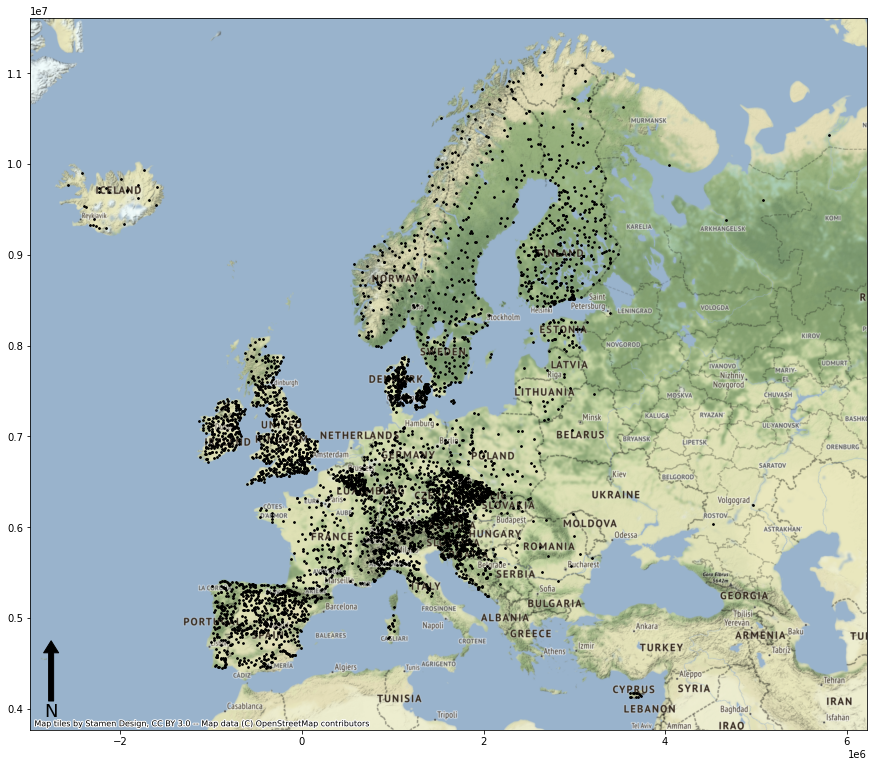

In [223]:
geospatialfunctions.plotpointsmap(network_EU.set_index("code").loc[:, ["lon", "lat"]], showcodes = False)

#### * Time-series read:

Here we read the time-series dataframes. It may take a while. 

In [215]:
# 1. Austria:
timeseries_AT = pd.read_excel(r"Austria\timeseries\timeseries_AT.xlsx", index_col=0)
timeseries_AT.index = pd.to_datetime(timeseries_AT.index)
timeseries_AT.index.name = "dates"

# 2. Belgium:
timeseries_BE = pd.read_excel(r"Julia\timeseries\timeseries_BE.xlsx", index_col=0)
timeseries_BE.index = pd.to_datetime(timeseries_BE.index)
timeseries_BE.index.name = "dates"

# 3. Belarus:
timeseries_BY = pd.read_excel(r"GRDC\timeseries\countries\timeseries_BY.xlsx", index_col=0)
timeseries_BY.index = pd.to_datetime(timeseries_BY.index)
timeseries_BY.index.name = "dates"

# 4. Bosnia and Herzegovina:
timeseries_BA = pd.read_excel(r"Bosnia\timeseries\timeseries_BA.xlsx", index_col=0)
timeseries_BA.index = pd.to_datetime(timeseries_BA.index)
timeseries_BA.index.name = "dates"

# 5. Croatia:
timeseries_HR = pd.read_excel(r"Croatia\timeseries\timeseries_HR.xlsx", index_col=0)
timeseries_HR.index = pd.to_datetime(timeseries_HR.index)
timeseries_HR.index.name = "dates"

# 6. Cyprus:
timeseries_CY = pd.read_excel(r"GRDC\timeseries\countries\timeseries_CY.xlsx", index_col=0)
timeseries_CY.index = pd.to_datetime(timeseries_CY.index)
timeseries_CY.index.name = "dates"

# 7. Czechia:
timeseries_CZ = pd.read_excel(r"Julia\timeseries\timeseries_CZ.xlsx", index_col=0)
timeseries_CZ.index = pd.to_datetime(timeseries_CZ.index)
timeseries_CZ.index.name = "dates"

# 8. Denmark
timeseries_DK = pd.read_excel(r"Julia\timeseries\timeseries_DK.xlsx", index_col=0)
timeseries_DK.index = pd.to_datetime(timeseries_DK.index)
timeseries_DK.index.name = "dates"

# 9. Estonia
timeseries_EE = pd.read_excel(r"GRDC\timeseries\countries\timeseries_EE.xlsx", index_col=0)
timeseries_EE.index = pd.to_datetime(timeseries_EE.index)
timeseries_EE.index.name = "dates"

# 10. Finland
timeseries_FI = pd.read_excel(r"Julia\timeseries\timeseries_FI.xlsx", index_col=0)
timeseries_FI.index = pd.to_datetime(timeseries_FI.index)
timeseries_FI.index.name = "dates"

# 11. France:
timeseries_FR = pd.read_excel(r"France\timeseries\timeseries_FR.xlsx", index_col=0)
timeseries_FR.index = pd.to_datetime(timeseries_FR.index)
timeseries_FR.index.name = "dates"

# 12. Germany
timeseries_DE = pd.read_excel(r"GRDC\timeseries\countries\timeseries_DE.xlsx", index_col=0)
timeseries_DE.index = pd.to_datetime(timeseries_DE.index)
timeseries_DE.index.name = "dates"

# 13. Greece

# 14. Great Britain:
timeseries_GB = pd.read_excel(r"GB\timeseries\timeseries_GB.xlsx", index_col=0)
timeseries_GB.index = pd.to_datetime(timeseries_GB.index)
timeseries_GB.index.name = "dates"

# 15. Hungary

# 16. Iceland
timeseries_IS = pd.read_excel(r"GRDC\timeseries\countries\timeseries_IS.xlsx", index_col=0)
timeseries_IS.index = pd.to_datetime(timeseries_IS.index)
timeseries_IS.index.name = "dates"

# 17. Ireland
timeseries_IE = pd.read_excel(r"Ireland\timeseries\timeseries_IE_full.xlsx", index_col=0)
timeseries_IE.index = pd.to_datetime(timeseries_IE.index)
timeseries_IE.index.name = "dates"

# 18. Italy
timeseries_IT = pd.read_excel(r"IT\timeseries\timeseries_IT.xlsx", index_col=0)
timeseries_IT.index = pd.to_datetime(timeseries_IT.index)
timeseries_IT.index.name = "dates"
# Pay attention that for Italy we do not have anymore any duplicated values. Ou network and time-series must be the same. 

# 19. Latvia:
timeseries_LV = pd.read_excel(r"GRDC\timeseries\countries\timeseries_LV.xlsx", index_col=0)
timeseries_LV.index = pd.to_datetime(timeseries_LV.index)
timeseries_LV.index.name = "dates"

# 20. Lithuania:
timeseries_LT = pd.read_excel(r"GRDC\timeseries\countries\timeseries_LT.xlsx", index_col=0)
timeseries_LT.index = pd.to_datetime(timeseries_LT.index)
timeseries_LT.index.name = "dates"

# 21. Luxembourg
timeseries_LU = pd.read_excel(r"Julia\timeseries\timeseries_LU.xlsx", index_col=0)
timeseries_LU.index = pd.to_datetime(timeseries_LU.index)
timeseries_LU.index.name = "dates"

# 22. Netherlands
timeseries_NL = pd.read_excel(r"Julia\timeseries\timeseries_NL.xlsx", index_col=0)
timeseries_NL.index = pd.to_datetime(timeseries_NL.index)
timeseries_NL.index.name = "dates"

# 23. Northern Ireland
timeseries_NI = pd.read_excel(r"NorthernIreland\timeseries\timeseries_NI.xlsx", index_col=0)
timeseries_NI.index = pd.to_datetime(timeseries_NI.index)
timeseries_NI.index.name = "dates"

# 24. Norway
timeseries_NO = pd.read_excel(r"Julia\timeseries\timeseries_NO.xlsx", index_col=0)
timeseries_NO.index = pd.to_datetime(timeseries_NO.index)
timeseries_NO.index.name = "dates"

# 25. Poland:
timeseries_PL = pd.read_excel(r"GRDC\timeseries\countries\timeseries_PL.xlsx", index_col=0)
timeseries_PL.index = pd.to_datetime(timeseries_PL.index)
timeseries_PL.index.name = "dates"

# 26. Portugal
timeseries_PT = pd.read_excel(r"Portugal\timeseries\timeseries_PT.xlsx", index_col=0)
timeseries_PT.index = pd.to_datetime(timeseries_PT.index)
timeseries_PT.index.name = "dates"

# 27. Romania:
timeseries_RO = pd.read_excel(r"GRDC\timeseries\countries\timeseries_RO.xlsx", index_col=0)
timeseries_RO.index = pd.to_datetime(timeseries_RO.index)
timeseries_RO.index.name = "dates"

# 28. Russia:
timeseries_RU = pd.read_excel(r"GRDC\timeseries\countries\timeseries_RU.xlsx", index_col=0)
timeseries_RU.index = pd.to_datetime(timeseries_RU.index)
timeseries_RU.index.name = "dates"

# 29. Serbia
timeseries_RS = pd.read_excel(r"Serbia\timeseries\timeseries_RS.xlsx", index_col=0)
timeseries_RS.index = pd.to_datetime(timeseries_RS.index)
timeseries_RS.index.name = "dates"

# 30. Slovakia
timeseries_SK = pd.read_excel(r"GRDC\timeseries\countries\timeseries_SK.xlsx", index_col=0)
timeseries_SK.index = pd.to_datetime(timeseries_SK.index)
timeseries_SK.index.name = "dates"

# 31. Slovenia
timeseries_SI = pd.read_excel(r"Slovenia\timeseries\timeseries_SI.xlsx", index_col=0)
timeseries_SI.index = pd.to_datetime(timeseries_SI.index)
timeseries_SI.index.name = "dates"

# 32. Spain
timeseries_ES = pd.read_excel(r"Spain\timeseries\timeseries_ES.xlsx", index_col=0)
timeseries_ES.index = pd.to_datetime(timeseries_ES.index)
timeseries_ES.index.name = "dates"

# 33. Sweden
timeseries_SE = pd.read_excel(r"Julia\timeseries\timeseries_SE.xlsx", index_col=0)
timeseries_SE.index = pd.to_datetime(timeseries_SE.index)
timeseries_SE.index.name = "dates"

# 34. Switzerland
timeseries_CH = pd.read_csv(r"Switzerland\timeseries\timeseries_CH.csv", index_col=0)
timeseries_CH.index = pd.to_datetime(timeseries_CH.index)
timeseries_CH.index.name = "dates"

Now we convert our columns to strings:

In [294]:
# 1. Austria:
timeseries_AT.columns = timeseries_AT.columns.astype(str)

# 2. Belgium:
timeseries_BE.columns = timeseries_BE.columns.astype(str)

# 3. Belarus:
timeseries_BY.columns = timeseries_BY.columns.astype(str)

# 4. Bosnia and Herzegovina:
timeseries_BA.columns = timeseries_BA.columns.astype(str)

# 5. Croatia:
timeseries_HR.columns = timeseries_HR.columns.astype(str)

# 6. Cyprus:
timeseries_CY.columns = timeseries_CY.columns.astype(str)

# 7. Czechia:
timeseries_CZ.columns = timeseries_CZ.columns.astype(str)

# 8. Denmark
timeseries_DK.columns = timeseries_DK.columns.astype(str)

# 9. Estonia
timeseries_EE.columns = timeseries_EE.columns.astype(str)

# 10. Finland
timeseries_FI.columns = timeseries_FI.columns.astype(str)

# 11. France:
timeseries_FR.columns = timeseries_FR.columns.astype(str)

# 12. Germany
timeseries_DE.columns = timeseries_DE.columns.astype(str)

# 13. Greece

# 14. Great Britain:
timeseries_GB.columns = timeseries_GB.columns.astype(str)

# 15. Hungary

# 16. Iceland
timeseries_IS.columns = timeseries_IS.columns.astype(str)

# 17. Ireland
timeseries_IE.columns = timeseries_IE.columns.astype(str)

# 18. Italy
timeseries_IT.columns = timeseries_IT.columns.astype(str)

# 19. Latvia:
timeseries_LV.columns = timeseries_LV.columns.astype(str)

# 20. Lithuania:
timeseries_LT.columns = timeseries_LT.columns.astype(str)

# 21. Luxembourg
timeseries_LU.columns = timeseries_LU.columns.astype(str)

# 22. Netherlands
timeseries_NL.columns = timeseries_NL.columns.astype(str)

# 23. Northern Ireland
timeseries_NI.columns = timeseries_NI.columns.astype(str)

# 24. Norway
timeseries_NO.columns = timeseries_NO.columns.astype(str)

# 25. Poland:
timeseries_PL.columns = timeseries_PL.columns.astype(str)

# 26. Portugal
timeseries_PT.columns = timeseries_PT.columns.astype(str)

# 27. Romania:
timeseries_RO.columns = timeseries_RO.columns.astype(str)

# 28. Russia:
timeseries_RU.columns = timeseries_RU.columns.astype(str)

# 29. Serbia
timeseries_RS.columns = timeseries_RS.columns.astype(str)

# 30. Slovakia
timeseries_SK.columns = timeseries_SK.columns.astype(str)

# 31. Slovenia
timeseries_SI.columns = timeseries_SI.columns.astype(str)

# 32. Spain
timeseries_ES.columns = timeseries_ES.columns.astype(str)

# 33. Sweden
timeseries_SE.columns = timeseries_SE.columns.astype(str)

# 34. Switzerland
timeseries_CH.columns = timeseries_CH.columns.astype(str)

#### * Time-series  concatenation:

It is important to first change the columns names to avoid any further problem with columns having the same name in our dataframe. 

It is also important to make sure that during the concatenation of the time-series, they follow the same order as the order used for the concatenation of the network.

In [319]:
dfs = [timeseries_AT.copy(), timeseries_BE.copy(), timeseries_BY.copy(), timeseries_BA.copy(), timeseries_HR.copy(), 
                             timeseries_CY.copy(), timeseries_CZ.copy(), timeseries_DK.copy(), timeseries_EE.copy(), 
                             timeseries_FI.copy(), timeseries_FR.copy(), timeseries_DE.copy(), timeseries_GB.copy(), 
                             timeseries_IS.copy(), timeseries_IE.copy(), timeseries_IT.copy(), timeseries_LV.copy(), 
                             timeseries_LT.copy(), timeseries_LU.copy(), timeseries_NL.copy(), timeseries_NI.copy(), 
                             timeseries_NO.copy(), timeseries_PL.copy(), timeseries_PT.copy(), timeseries_RO.copy(), 
                             timeseries_RU.copy(), timeseries_RS.copy(), timeseries_SK.copy(), timeseries_SI.copy(), 
                             timeseries_ES.copy(), timeseries_SE.copy(), timeseries_CH.copy()]

In [320]:
timeseries_EU = pd.DataFrame(index = pd.date_range('01-01-1920','12-31-2022', freq='D'))

countries = network_EU['country'].unique()
i = 0
for df in tqdm.tqdm(dfs):
    # Here we set the country:
    country = countries[i]
    
    # Now we create a mask:
    mask = network_EU['country'] == country
    
    # Create a dictionary mapping codes to new column names
    code_to_column = dict(zip(network_EU.loc[mask, 'code'] , network_EU.loc[mask, 'new_code'] ))

    # Method 1: Using map()
    df.columns = df.columns.map(code_to_column)
    
    # Here we concatenate it:
    timeseries_EU = pd.concat([timeseries_EU, df], axis=1)

    i = i + 1
    

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.88it/s]


In [297]:
timeseries_EU

,AT0001,AT0002,AT0003,AT0004,AT0005,AT0006,AT0007,AT0008,AT0009,AT0010,...,CH0101,CH0102,CH0103,CH0104,CH0105,CH0106,CH0107,CH0108,CH0109,CH0110
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we save our dataframes:

In [345]:
network_EU.to_excel(r'EU\network_EU.xlsx') 
timeseries_EU.loc["1950":"2022", :].to_csv(r'EU\timeseries_EU.csv')